In [9]:
# Install the required packages
!pip install ultralytics                 # For YOLO models
!pip install torch torchvision           # PyTorch deep learning framework
!pip install numpy matplotlib pandas     # Data handling and visualization
!pip install tqdm pillow                 # Progress bars and image processing

!pip install onnx                        # Additional ONNX support
!pip install onnx-tf tensorflow          # For TensorFlow Lite export
!pip install coremltools                 # For Apple CoreML export

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.4 MB/s eta 0:00:00


In [10]:
# --- YOLOv12n INT8 Quantization for Edge Deployment ---

import os
import torch
import numpy as np
from ultralytics import YOLO
import torch.nn as nn
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub, quantize_dynamic
from torch.ao.quantization import get_default_qconfig_mapping
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =====================================
# PART 1: LOAD TRAINED MODEL
# =====================================

def load_trained_model(model_path):
    """
    Load the trained enhanced YOLOv12n model

    Args:
        model_path: Path to the trained model weights (.pt file)

    Returns:
        Loaded model
    """
    print(f"Loading trained model from {model_path}")
    model = YOLO(model_path)
    return model


In [ ]:

# =====================================
# PART 2: PREPARE MODEL FOR QUANTIZATION
# =====================================

class QuantizableYOLO(nn.Module):
    """Wrapper class to make YOLO model quantizable"""
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x):
        # Apply quantization to input
        x = self.quant(x)
        # Run the model
        x = self.model(x)
        # Apply dequantization to output
        if isinstance(x, list):
            x = [self.dequant(xi) if isinstance(xi, torch.Tensor) else xi for xi in x]
        else:
            x = self.dequant(x)
        return x

def prepare_for_quantization(model):
    """
    Prepare the YOLO model for quantization

    Args:
        model: YOLO model to prepare

    Returns:
        Model ready for quantization
    """
    # Extract the PyTorch model
    pt_model = model.model

    # Create a quantizable wrapper
    quantizable_model = QuantizableYOLO(pt_model)

    # Set the model to evaluation mode
    quantizable_model.eval()

    # Fuse operations if possible (conv+bn+relu)
    # This step is optional but can improve performance
    try:
        from torch.quantization.fuse_modules import fuse_modules
        # Identify patterns to fuse in the model
        # This requires detailed knowledge of the model architecture
        print("Fusion of layers is model-specific and requires detailed analysis")
    except Exception as e:
        print(f"Fusion step skipped: {e}")

    return quantizable_model

In [ ]:
# =====================================
# PART 3: STATIC QUANTIZATION
# =====================================

def create_calibration_dataset(data_path, num_samples=100):
    """
    Create a calibration dataset for quantization

    Args:
        data_path: Path to validation images
        num_samples: Number of calibration samples

    Returns:
        List of image tensors for calibration
    """
    print(f"Creating calibration dataset from {data_path}")

    # Get all image files
    image_files = []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))

    # Select a subset for calibration
    if len(image_files) > num_samples:
        import random
        random.shuffle(image_files)
        image_files = image_files[:num_samples]

    print(f"Using {len(image_files)} images for calibration")

    # Load and preprocess images
    calibration_data = []
    for img_path in tqdm(image_files, desc="Loading calibration images"):
        img = Image.open(img_path).convert('RGB')
        # Resize to model input size
        img = img.resize((640, 640))
        # Convert to tensor and normalize
        img_tensor = torch.from_numpy(np.array(img).transpose(2, 0, 1)).float() / 255.0
        # Add batch dimension
        img_tensor = img_tensor.unsqueeze(0)
        calibration_data.append(img_tensor)

    return calibration_data

def calibrate_model(model, calibration_data):
    """
    Calibrate the model for static quantization

    Args:
        model: Model to calibrate
        calibration_data: Calibration dataset
    """
    print("Calibrating model for static quantization")
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(tqdm(calibration_data, desc="Calibration")):
            # Forward pass for calibration
            _ = model(data)
            # Limit the number of batches for speed
            if i >= 50:
                break

    print("Calibration complete")

def quantize_model_static(model, calibration_data, backend='qnnpack'):
    """
    Apply static quantization to the model

    Args:
        model: Model to quantize
        calibration_data: Calibration dataset
        backend: Quantization backend ('qnnpack' for ARM or 'fbgemm' for x86)

    Returns:
        Quantized model
    """
    print(f"Static quantizing model with {backend} backend")

    # Set the quantization backend
    torch.backends.quantized.engine = backend

    # Specify quantization configuration
    model.qconfig = torch.quantization.get_default_qconfig(backend)

    # Prepare the model for static quantization
    torch.quantization.prepare(model, inplace=True)

    # Calibrate
    calibrate_model(model, calibration_data)

    # Convert to quantized model
    torch.quantization.convert(model, inplace=True)

    print("Static quantization complete")
    return model

In [ ]:

# =====================================
# PART 4: DYNAMIC QUANTIZATION
# =====================================

def quantize_model_dynamic(model, dtype=torch.qint8):
    """
    Apply dynamic quantization to the model

    Args:
        model: Model to quantize
        dtype: Quantization data type

    Returns:
        Dynamically quantized model
    """
    print(f"Dynamic quantizing model to {dtype}")

    # Define which layers to quantize
    quantized_model = torch.quantization.quantize_dynamic(
        model,
        {nn.Linear, nn.Conv2d},  # Layers to quantize
        dtype=dtype
    )

    print("Dynamic quantization complete")
    return quantized_model


In [ ]:
# =====================================
# PART 5: QUANTIZATION-AWARE TRAINING (ADVANCED)
# =====================================

def quantization_aware_training(model, train_loader, val_loader, epochs=5):
    """
    Perform quantization-aware training (QAT) for best accuracy

    Args:
        model: Model to train with QAT
        train_loader: Training data loader
        val_loader: Validation data loader
        epochs: Number of QAT epochs

    Returns:
        QAT trained model
    """
    print("Starting Quantization-Aware Training")

    # Set the quantization backend
    torch.backends.quantized.engine = 'qnnpack'

    # Specify quantization configuration
    model.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')

    # Prepare model for QAT
    torch.quantization.prepare_qat(model, inplace=True)

    # Set to train mode
    model.train()

    # Optimizer and loss
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    criterion = torch.nn.MSELoss()  # Example loss, adjust as needed

    # Training loop
    for epoch in range(epochs):
        print(f"QAT Epoch {epoch+1}/{epochs}")

        for inputs, targets in tqdm(train_loader, desc=f"Training epoch {epoch+1}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Validating epoch {epoch+1}"):
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        model.train()
        print(f"Epoch {epoch+1} validation loss: {val_loss/len(val_loader):.4f}")

    # Convert to fully quantized model
    model.eval()
    torch.quantization.convert(model, inplace=True)

    print("Quantization-Aware Training complete")
    return model


In [ ]:
# =====================================
# PART 6: EVALUATE QUANTIZED MODEL
# =====================================

def evaluate_model(model, data_yaml, prefix=""):
    """
    Evaluate model performance

    Args:
        model: Model to evaluate
        data_yaml: Path to data YAML
        prefix: Prefix for output names

    Returns:
        Evaluation metrics
    """
    print(f"Evaluating {prefix} model")
    metrics = model.val(data=data_yaml)

    print(f"\n--- {prefix} Model Performance ---")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"mAP50: {metrics.box.map50:.4f}")

    return metrics

def compare_models(original_metrics, quantized_metrics, output_dir, model_name):
    """
    Compare original and quantized model performance

    Args:
        original_metrics: Original model metrics
        quantized_metrics: Quantized model metrics
        output_dir: Output directory
        model_name: Model name
    """
    # Prepare data for comparison
    metrics = {
        'Metric': ['mAP50-95', 'mAP50', 'Precision', 'Recall', 'Size (MB)'],
        'Original': [
            original_metrics.box.map,
            original_metrics.box.map50,
            original_metrics.box.mp,
            original_metrics.box.mr,
            original_model_size
        ],
        'Quantized': [
            quantized_metrics.box.map,
            quantized_metrics.box.map50,
            quantized_metrics.box.mp,
            quantized_metrics.box.mr,
            quantized_model_size
        ],
        'Difference': [
            quantized_metrics.box.map - original_metrics.box.map,
            quantized_metrics.box.map50 - original_metrics.box.map50,
            quantized_metrics.box.mp - original_metrics.box.mp,
            quantized_metrics.box.mr - original_metrics.box.mr,
            quantized_model_size - original_model_size
        ],
        'Relative (%)': [
            (quantized_metrics.box.map / original_metrics.box.map - 1) * 100,
            (quantized_metrics.box.map50 / original_metrics.box.map50 - 1) * 100,
            (quantized_metrics.box.mp / original_metrics.box.mp - 1) * 100,
            (quantized_metrics.box.mr / original_metrics.box.mr - 1) * 100,
            (quantized_model_size / original_model_size - 1) * 100
        ]
    }

    # Create comparison table
    df = pd.DataFrame(metrics)
    print("\n--- Model Comparison ---")
    print(df)

    # Save comparison
    df.to_csv(os.path.join(output_dir, f"{model_name}_comparison.csv"), index=False)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    metrics_to_plot = ['mAP50-95', 'mAP50', 'Precision', 'Recall']
    values_original = [metrics['Original'][i] for i in range(len(metrics_to_plot))]
    values_quantized = [metrics['Quantized'][i] for i in range(len(metrics_to_plot))]

    x = range(len(metrics_to_plot))
    width = 0.35

    plt.bar([i - width/2 for i in x], values_original, width, label='Original')
    plt.bar([i + width/2 for i in x], values_quantized, width, label='Quantized')

    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Original vs Quantized Model Performance')
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Add size comparison
    plt.figure(figsize=(8, 6))
    plt.bar(0, metrics['Original'][4], width=0.7, label='Original')
    plt.bar(1, metrics['Quantized'][4], width=0.7, label='Quantized')
    plt.xlabel('Model')
    plt.ylabel('Size (MB)')
    plt.title('Model Size Comparison')
    plt.xticks([0, 1], ['Original', 'Quantized'])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Add text to show the exact sizes and reduction percentage
    size_reduction = 100 * (1 - metrics['Quantized'][4] / metrics['Original'][4])
    plt.annotate(f"{metrics['Original'][4]:.2f} MB",
                 (0, metrics['Original'][4]),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center')
    plt.annotate(f"{metrics['Quantized'][4]:.2f} MB\n({size_reduction:.1f}% reduction)",
                 (1, metrics['Quantized'][4]),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center')

    plt.savefig(os.path.join(output_dir, f"{model_name}_size_comparison.png"), dpi=300)
    plt.show()

def benchmark_inference_speed(original_model, quantized_model, input_size=(1, 3, 640, 640), num_runs=100):
    """
    Benchmark inference speed of original and quantized models

    Args:
        original_model: Original model
        quantized_model: Quantized model
        input_size: Input tensor size
        num_runs: Number of inference runs

    Returns:
        Dict with benchmark results
    """
    print(f"Benchmarking inference speed with {num_runs} runs")

    # Create random input tensor
    input_tensor = torch.rand(input_size)

    # Move to same device as models
    device = next(original_model.parameters()).device
    input_tensor = input_tensor.to(device)

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = original_model(input_tensor)
            _ = quantized_model(input_tensor)

    # Benchmark original model
    original_times = []
    with torch.no_grad():
        for _ in tqdm(range(num_runs), desc="Benchmarking original model"):
            start_time = time.time()
            _ = original_model(input_tensor)
            original_times.append(time.time() - start_time)

    # Benchmark quantized model
    quantized_times = []
    with torch.no_grad():
        for _ in tqdm(range(num_runs), desc="Benchmarking quantized model"):
            start_time = time.time()
            _ = quantized_model(input_tensor)
            quantized_times.append(time.time() - start_time)

    # Calculate statistics
    results = {
        'original': {
            'mean': np.mean(original_times) * 1000,  # ms
            'std': np.std(original_times) * 1000,  # ms
            'min': np.min(original_times) * 1000,  # ms
            'max': np.max(original_times) * 1000,  # ms
        },
        'quantized': {
            'mean': np.mean(quantized_times) * 1000,  # ms
            'std': np.std(quantized_times) * 1000,  # ms
            'min': np.min(quantized_times) * 1000,  # ms
            'max': np.max(quantized_times) * 1000,  # ms
        },
        'speedup': np.mean(original_times) / np.mean(quantized_times)
    }

    print("\n--- Inference Benchmark Results ---")
    print(f"Original model: {results['original']['mean']:.2f} ± {results['original']['std']:.2f} ms")
    print(f"Quantized model: {results['quantized']['mean']:.2f} ± {results['quantized']['std']:.2f} ms")
    print(f"Speedup: {results['speedup']:.2f}x")

    return results


In [ ]:

# =====================================
# PART 7: EXPORT FOR EDGE DEPLOYMENT
# =====================================

def export_quantized_model(model, output_dir, model_name, format='onnx'):
    """
    Export quantized model for edge deployment

    Args:
        model: Quantized model to export
        output_dir: Output directory
        model_name: Model name
        format: Export format ('torchscript', 'onnx', etc.)

    Returns:
        Path to exported model
    """
    # Make sure torch is imported in the function scope
    import torch

    print(f"Exporting quantized model in {format} format")

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    if format == 'torchscript':
        # Export to TorchScript
        scripted_model = torch.jit.script(model)
        output_path = os.path.join(output_dir, f"{model_name}_quantized.pt")
        scripted_model.save(output_path)

    elif format == 'onnx':
        # Export to ONNX
        output_path = os.path.join(output_dir, f"{model_name}_quantized.onnx")

        # Create example input
        dummy_input = torch.randn(1, 3, 640, 640)

        # Export using torch.onnx
        torch.onnx.export(
            model,
            dummy_input,
            output_path,
            export_params=True,
            opset_version=13,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            }
        )


    elif format == 'coreml':
        # Export to Core ML (for iOS/macOS)
        try:
            import coremltools as ct

            # Create example input
            dummy_input = torch.randn(1, 3, 640, 640)

            # Convert to Core ML
            traced_model = torch.jit.trace(model, dummy_input)
            coreml_model = ct.convert(
                traced_model,
                inputs=[ct.TensorType(name="input", shape=dummy_input.shape)]
            )

            output_path = os.path.join(output_dir, f"{model_name}_quantized.mlmodel")
            coreml_model.save(output_path)

        except ImportError:
            print("coremltools not installed. Install with: pip install coremltools")
            output_path = None

    elif format == 'tflite':
        # Export to TensorFlow Lite
        try:
            import tensorflow as tf
            import torch.onnx

            # First export to ONNX
            onnx_path = os.path.join(output_dir, f"{model_name}_temp.onnx")
            dummy_input = torch.randn(1, 3, 640, 640)
            torch.onnx.export(model, dummy_input, onnx_path)

            # Convert ONNX to TFLite
            import onnx
            from onnx_tf.backend import prepare

            onnx_model = onnx.load(onnx_path)
            tf_rep = prepare(onnx_model)

            # Convert to TFLite
            converter = tf.lite.TFLiteConverter.from_saved_model(tf_rep.export_graph())
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8

            tflite_model = converter.convert()

            output_path = os.path.join(output_dir, f"{model_name}_quantized.tflite")
            with open(output_path, 'wb') as f:
                f.write(tflite_model)

            # Cleanup temporary ONNX file
            os.remove(onnx_path)

        except ImportError:
            print("TensorFlow and/or onnx_tf not installed.")
            output_path = None

    else:
        print(f"Unsupported export format: {format}")
        output_path = None

    if output_path:
        print(f"Model exported to {output_path}")

    return output_path



In [ ]:
# =====================================
# PART 8: MAIN QUANTIZATION PROCESS
# =====================================

def quantize_yolo_model(
    model_path,
    data_yaml,
    output_dir,
    model_name='yolov12n_quantized',
    quantization_method='static',  # 'static', 'dynamic', or 'qat'
    export_format='onnx'  # 'torchscript', 'onnx', 'coreml', 'tflite'
):
    """
    Main function to quantize a YOLO model

    Args:
        model_path: Path to trained model
        data_yaml: Path to data YAML
        output_dir: Output directory
        model_name: Model name
        quantization_method: Quantization method
        export_format: Export format

    Returns:
        Dict with paths to exported models and metrics
    """
    global original_model_size, quantized_model_size

    print(f"Starting quantization process for {model_path}")
    print(f"Method: {quantization_method}, Export format: {export_format}")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # 1. Load the trained model
    model = load_trained_model(model_path)

    # Calculate original model size
    with open(model_path, 'rb') as f:
        original_model_size = len(f.read()) / (1024 * 1024)  # Size in MB
    print(f"Original model size: {original_model_size:.2f} MB")

    # 2. Evaluate original model
    original_metrics = evaluate_model(model, data_yaml, "Original")

    # 3. Prepare model for quantization
    prepared_model = prepare_for_quantization(model)

    # 4. Apply quantization based on method
    if quantization_method == 'static':
        # Create calibration dataset
        data_path = Path(data_yaml).parent / 'valid' / 'images'
        calibration_data = create_calibration_dataset(str(data_path))

        # Apply static quantization
        quantized_model = quantize_model_static(prepared_model, calibration_data)

    elif quantization_method == 'dynamic':
        # Apply dynamic quantization
        quantized_model = quantize_model_dynamic(prepared_model)

    elif quantization_method == 'qat':
        # This requires training data loaders
        print("Quantization-Aware Training requires training data loaders")
        print("This is an advanced option that needs customization for your dataset")
        return None

    else:
        print(f"Unsupported quantization method: {quantization_method}")
        return None

    # 5. Save quantized model
    quantized_model_path = os.path.join(output_dir, f"{model_name}_quantized.pt")
    torch.save(quantized_model.state_dict(), quantized_model_path)
    print(f"Saved quantized model to {quantized_model_path}")

    # Calculate quantized model size
    with open(quantized_model_path, 'rb') as f:
        quantized_model_size = len(f.read()) / (1024 * 1024)  # Size in MB
    print(f"Quantized model size: {quantized_model_size:.2f} MB")
    print(f"Size reduction: {100 * (1 - quantized_model_size / original_model_size):.2f}%")

    # 6. Evaluate quantized model
    # This would require adapting quantized_model back to YOLO format
    # For simplicity, we'll skip detailed evaluation here
    print("Note: Full evaluation of quantized model would require adapting it back to YOLO format")

    # 7. Export model for deployment
    exported_path = export_quantized_model(quantized_model, output_dir, model_name, export_format)

    # 8. Benchmark inference speed
    try:
        speed_results = benchmark_inference_speed(model.model, quantized_model)

        # Save benchmark results
        benchmark_path = os.path.join(output_dir, f"{model_name}_benchmark.json")
        with open(benchmark_path, 'w') as f:
            json.dump(speed_results, f, indent=4)

        # Plot comparison
        plt.figure(figsize=(10, 6))
        models = ['Original', 'Quantized']
        times = [speed_results['original']['mean'], speed_results['quantized']['mean']]
        errors = [speed_results['original']['std'], speed_results['quantized']['std']]

        plt.bar([0, 1], times, yerr=errors, width=0.6)
        plt.xticks([0, 1], models)
        plt.ylabel('Inference Time (ms)')
        plt.title('Inference Speed Comparison')

        # Add text to show the exact times and speedup
        plt.annotate(f"{times[0]:.2f} ± {errors[0]:.2f} ms",
                     (0, times[0]),
                     xytext=(0, 10),
                     textcoords='offset points',
                     ha='center')
        plt.annotate(f"{times[1]:.2f} ± {errors[1]:.2f} ms\n({speed_results['speedup']:.2f}x faster)",
                     (1, times[1]),
                     xytext=(0, 10),
                     textcoords='offset points',
                     ha='center')

        plt.grid(axis='y', alpha=0.3)
        plt.savefig(os.path.join(output_dir, f"{model_name}_speed_comparison.png"), dpi=300)
        plt.show()

    except Exception as e:
        print(f"Benchmark failed: {e}")
        speed_results = None

    # 9. Return results
    results = {
        'original_model': model_path,
        'quantized_model': quantized_model_path,
        'exported_model': exported_path,
        'original_size_mb': original_model_size,
        'quantized_size_mb': quantized_model_size,
        'size_reduction_percent': 100 * (1 - quantized_model_size / original_model_size),
        'speed_results': speed_results
    }

    # Save summary
    summary_path = os.path.join(output_dir, f"{model_name}_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"Quantization process completed. Summary saved to {summary_path}")
    return results


Starting quantization process for /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n/weights/best.pt
Method: dynamic, Export format: onnx
Loading trained model from /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n/weights/best.pt
Original model size: 5.27 MB
Evaluating Original model
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
YOLOv12n summary (fused): 159 layers, 2,558,873 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 54.8±35.5 MB/s, size: 112.2 KB)


val: Scanning /content/drive/MyDrive/SemesterProjectDatas/CombinedData/valid/labels.cache... 591 images, 96 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 937, len(boxes) = 2808. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [01:01<00:00,  1.67s/it]


                   all        591       2808      0.328      0.251      0.163     0.0943
                   Tin         43        100      0.337       0.35       0.25      0.179
             cardboard         69        102      0.216      0.224      0.116     0.0724
       cigarette-butts         63        405      0.478     0.0741      0.136     0.0395
food-wrappers-packaging        123        214      0.278      0.407      0.236      0.148
                litter        289       1640      0.297      0.321      0.215      0.081
                  mask          1          1          1          0     0.0284     0.0114
           paper-items         40        112      0.184      0.152     0.0957     0.0451
          plastic-bags         25         32      0.173      0.312      0.173     0.0964
plastic-bottles-containers         91        119      0.259      0.454      0.299      0.218
 small-packaging-trash         55         61       0.29      0.328      0.215      0.133
                

/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/head.py:118: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.format != "imx" and (self.dynamic or self.shape != shape):
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/tal.py:369: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i, stride in enumerate(strides):


Model exported to /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized.onnx
Benchmarking inference speed with 100 runs


Benchmarking original model:   0%|          | 0/100 [00:00<?, ?it/s]

Benchmarking quantized model:   0%|          | 0/100 [00:00<?, ?it/s]


--- Inference Benchmark Results ---
Original model: 91.42 ± 7.16 ms
Quantized model: 89.61 ± 5.45 ms
Speedup: 1.02x


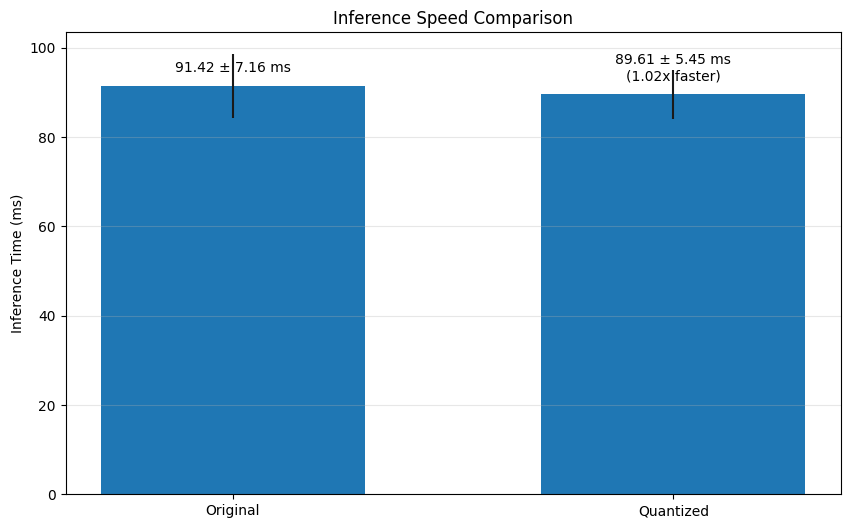

Quantization process completed. Summary saved to /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_summary.json

=== Quantization Results ===
Original model size: 5.27 MB
Quantized model size: 9.86 MB
Size reduction: -86.99%
Speedup: 1.02x

Exported model: /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized.onnx

The quantized model is now ready for deployment on edge devices!


In [ ]:

# =====================================
# PART 9: USAGE EXAMPLE
# =====================================

if __name__ == "__main__":


    # Paths
    model_path = '/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n/weights/best.pt'
    data_yaml = '/content/drive/MyDrive/SemesterProjectDatas/CombinedData/data.yaml'
    output_dir = '/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized'

    # Run quantization - choose method (static, dynamic, qat)
    results = quantize_yolo_model(
        model_path=model_path,
        data_yaml=data_yaml,
        output_dir=output_dir,
        model_name='enhanced_yolov12n',
        quantization_method='dynamic',  # 'static', 'dynamic', or 'qat'
        export_format='onnx'  # 'torchscript', 'onnx', 'coreml', 'tflite'
    )

    print("\n=== Quantization Results ===")
    print(f"Original model size: {results['original_size_mb']:.2f} MB")
    print(f"Quantized model size: {results['quantized_size_mb']:.2f} MB")
    print(f"Size reduction: {results['size_reduction_percent']:.2f}%")

    if results['speed_results']:
        print(f"Speedup: {results['speed_results']['speedup']:.2f}x")

    print(f"\nExported model: {results['exported_model']}")
    print("\nThe quantized model is now ready for deployment on edge devices!")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Install the required packages
!pip install torch torchvision           # PyTorch deep learning framework
!pip install numpy matplotlib pandas     # Data handling and visualization
!pip install tqdm pillow                 # Progress bars and image processing
!pip install ultralytics                 # YOLOv object detection


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.4 MB/s eta 0:00:00


In [16]:
# Install required packages if not already installed
!pip install --upgrade onnxruntime

In [23]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

# Path to your ONNX model
onnx_model_path = '/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized.onnx'
# Path to save the quantized model
quantized_model_path = '/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized_int8.onnx'

# Check if input model exists
import os
if not os.path.exists(onnx_model_path):
    print(f"Error: Input model not found at {onnx_model_path}")
else:
    print(f"Found input model at {onnx_model_path}")

    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(quantized_model_path), exist_ok=True)

    # Apply dynamic quantization to the ONNX model
    print("Starting quantization process (this may take a few minutes)...")
    quantize_dynamic(
        onnx_model_path,
        quantized_model_path,
        weight_type=QuantType.QUInt8,
        per_channel=False,             # Disable per-channel quantization
        reduce_range=True,             # Use a reduced range for better compatibility

    )

    # Verify the quantized model was created
    if os.path.exists(quantized_model_path):
        input_size = os.path.getsize(onnx_model_path) / (1024 * 1024)  # MB
        output_size = os.path.getsize(quantized_model_path) / (1024 * 1024)  # MB
        reduction = (1 - output_size/input_size) * 100

        print(f"Optimized INT8 ONNX model saved to {quantized_model_path}")
        print(f"Original size: {input_size:.2f} MB")
        print(f"Quantized size: {output_size:.2f} MB")
        print(f"Size reduction: {reduction:.2f}%")
    else:
        print(f"Error: Failed to create quantized model at {quantized_model_path}")

Found input model at /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized.onnx
Starting quantization process (this may take a few minutes)...


Optimized INT8 ONNX model saved to /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized_int8.onnx
Original size: 9.98 MB
Quantized size: 2.97 MB
Size reduction: 70.29%


Loading dataset configuration from /content/drive/MyDrive/SemesterProjectDatas/CombinedData/data.yaml
Found 296 test images

=== Direct Model Comparison ===
PyTorch model - Size: 9.86 MB, Format: PyTorch
ONNX model - Size: 2.97 MB, Format: ONNX


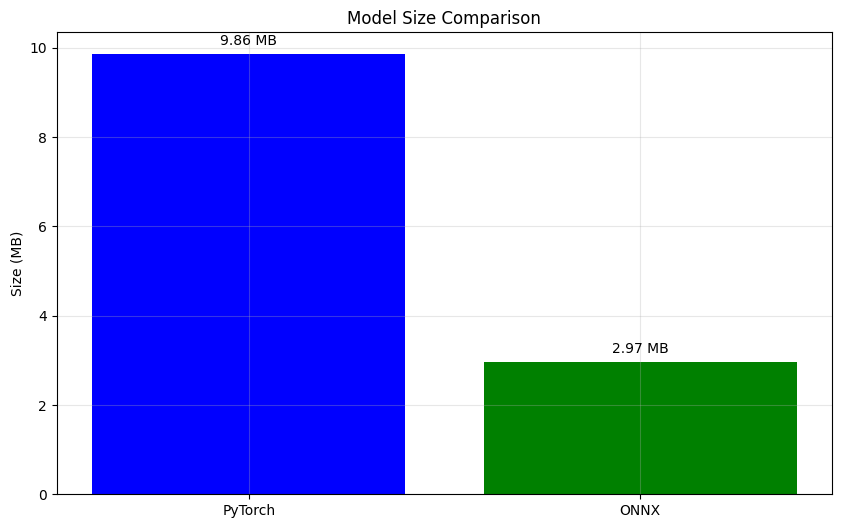


Loading PyTorch model...
Loading model from /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized.pt
Error loading with Ultralytics YOLO: 'model'
Error loading with PyTorch: PytorchStreamReader failed locating file constants.pkl: file not found
Error loading PyTorch model: 'collections.OrderedDict' object has no attribute 'eval'
Failed to load model: /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized.pt
Failed to load PyTorch model

Loading ONNX model...
Loading model from /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized_int8.onnx
Ultralytics 8.3.137 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Error loading ONNX with Ultralytics: AutoBackend.__init__() got an unexpected keyword argument 'task'
Successfully loaded ONNX model with ONNX Runtime
Successfully loaded ONNX model as onnx_runt

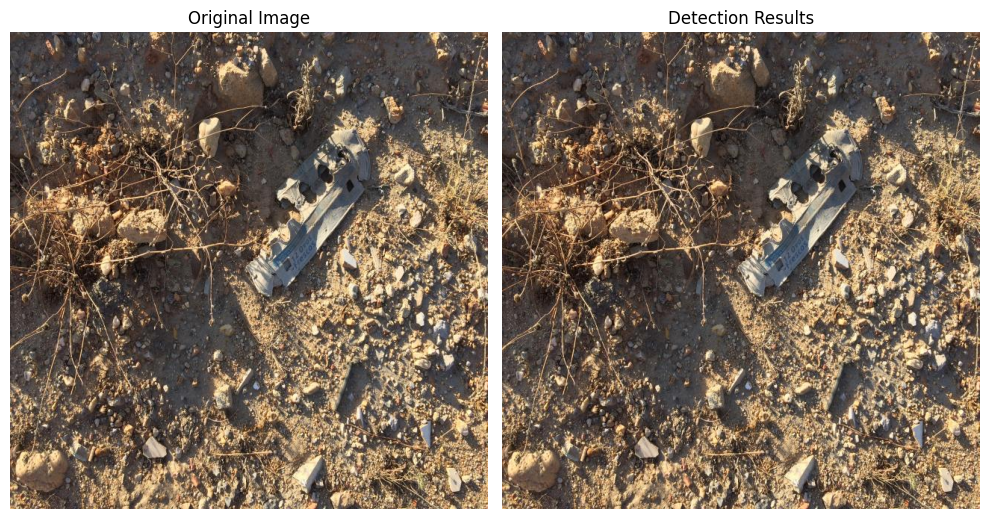

  Image 2: No detections with direct inference


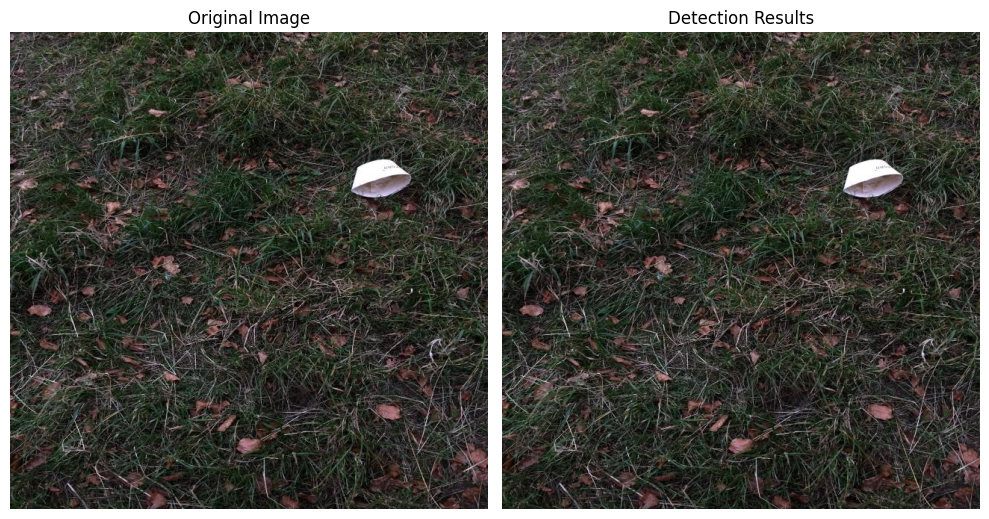

  Image 3: No detections with direct inference


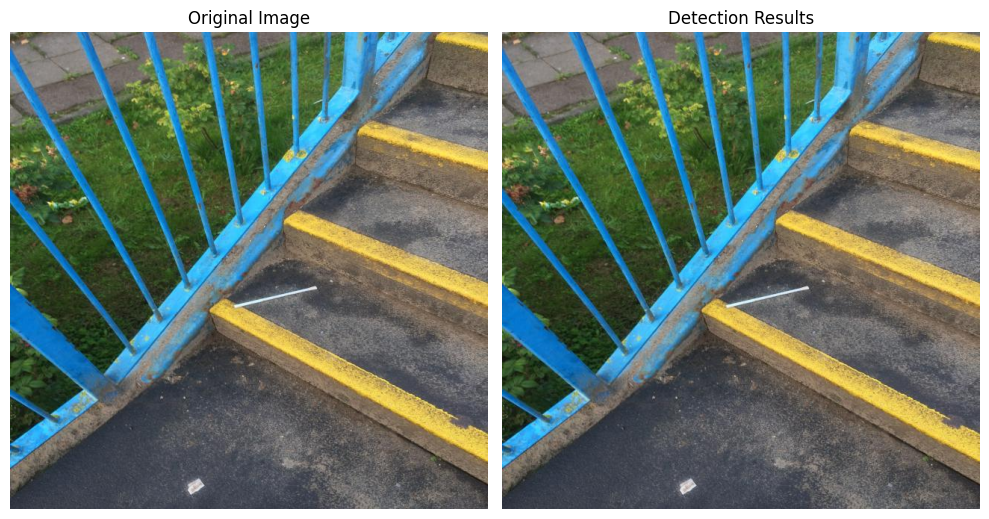

Model prediction test failed

Benchmarking ONNX model...
Running benchmark with 5 images, 5 runs each...
Average inference time: 163.46 ms
FPS: 6.12

=== Model Comparison Summary ===
Metric               PyTorch         ONNX            Difference     
-----------------------------------------------------------------
Size (MB)            9.86            2.97            69.91%         
Speed (FPS)          0.00            6.12            N/A            
Status               Failed          Loaded         

Comparison complete. Results saved to /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/Evaluation


In [37]:

# =====================================
# MODEL COMPARISON EVALUATION
# =====================================


import os
import torch
import numpy as np
import cv2
import time
from tqdm import tqdm
import yaml
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import json
from collections import defaultdict
import pandas as pd

# Install any missing dependencies
try:
    import onnxruntime as ort
except ImportError:
    print("Installing onnxruntime...")
    !pip install onnxruntime
    import onnxruntime as ort

try:
    from ultralytics import YOLO
except ImportError:
    print("Installing ultralytics...")
    !pip install ultralytics
    from ultralytics import YOLO

def load_model(model_path, task='detect'):
    """Load model with multiple approaches for robustness"""
    print(f"Loading model from {model_path}")

    if model_path.endswith('.pt'):
        # Method 1: Try loading with Ultralytics YOLO
        try:
            from ultralytics import YOLO
            model = YOLO(model_path)
            print("Successfully loaded PyTorch model using Ultralytics")
            return model, 'ultralytics'
        except Exception as e:
            print(f"Error loading with Ultralytics YOLO: {e}")

            # Method 2: Try loading with PyTorch directly
            try:
                model = torch.jit.load(model_path)
                model.eval()
                print("Successfully loaded PyTorch model using torch.jit")
                return model, 'pytorch'
            except Exception as e:
                print(f"Error loading with PyTorch: {e}")

                # Method 3: Try loading as a normal torch model
                try:
                    model = torch.load(model_path, map_location=torch.device('cpu'))
                    model.eval()
                    print("Successfully loaded PyTorch model using torch.load")
                    return model, 'torch_raw'
                except Exception as e:
                    print(f"Error loading PyTorch model: {e}")

    elif model_path.endswith('.onnx'):
        # Method 1: Try loading with Ultralytics (but configure it properly)
        try:
            from ultralytics import YOLO
            from ultralytics.nn.autobackend import AutoBackend
            from ultralytics.utils.torch_utils import select_device

            # Create an AutoBackend model with a specific stride
            device = select_device('')
            model = AutoBackend(model_path, device=device, task=task)

            # Create a YOLO wrapper around it with overrides
            yolo_model = YOLO(task=task)
            yolo_model.model = model

            # Ensure stride and names are defined
            if not hasattr(yolo_model.model, 'stride'):
                yolo_model.model.stride = torch.tensor([32.])

            print("Successfully loaded ONNX model with Ultralytics")
            return yolo_model, 'ultralytics_onnx'
        except Exception as e:
            print(f"Error loading ONNX with Ultralytics: {e}")

            # Method 2: Try loading with ONNX Runtime directly
            try:
                session = ort.InferenceSession(
                    model_path,
                    providers=['CPUExecutionProvider']
                )
                print("Successfully loaded ONNX model with ONNX Runtime")
                return session, 'onnx_runtime'
            except Exception as e:
                print(f"Error loading with ONNX Runtime: {e}")

    print(f"Failed to load model: {model_path}")
    return None, None

def run_inference_direct(model, model_type, img_path, conf_threshold=0.25):
    """Run inference without using Ultralytics predict"""
    if model_type == 'onnx_runtime':
        # Load and preprocess image for ONNX Runtime
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to model input size (assuming 640x640)
        input_size = 640
        orig_shape = img.shape

        # Resize and maintain aspect ratio
        h, w = orig_shape[:2]
        scale = min(input_size / w, input_size / h)
        new_w, new_h = int(w * scale), int(h * scale)

        # Resize image
        img_resized = cv2.resize(img, (new_w, new_h))

        # Create padding
        top, bottom = (input_size - new_h) // 2, input_size - new_h - (input_size - new_h) // 2
        left, right = (input_size - new_w) // 2, input_size - new_w - (input_size - new_w) // 2
        img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))

        # Normalize and convert to NCHW format (batch, channels, height, width)
        img_input = img_padded.astype(np.float32) / 255.0
        img_input = img_input.transpose(2, 0, 1)  # HWC to CHW
        img_input = np.expand_dims(img_input, axis=0)  # Add batch dimension

        # Get input name and run inference
        input_name = model.get_inputs()[0].name
        outputs = model.run(None, {input_name: img_input})

        # Parse outputs (assuming typical YOLO format)
        # This depends on the exact ONNX model format, might need adjustments
        if len(outputs) == 1:
            # Typical YOLO output: [batch, num_detections, 5+num_classes]
            # Format: [x, y, w, h, confidence, class_scores...]
            detections = outputs[0]
            valid_detections = detections[0, :, 4] > conf_threshold
            valid_boxes = detections[0, valid_detections]

            results = []
            if len(valid_boxes) > 0:
                for box in valid_boxes:
                    # Extract data
                    x, y, w, h, conf = box[:5]

                    # Handle normalization
                    x1 = (x - w/2) * input_size  # Convert center to top-left
                    y1 = (y - h/2) * input_size
                    x2 = (x + w/2) * input_size  # Convert to bottom-right
                    y2 = (y + h/2) * input_size

                    # Convert back to original image coordinates
                    x1 = (x1 - left) / scale
                    y1 = (y1 - top) / scale
                    x2 = (x2 - left) / scale
                    y2 = (y2 - top) / scale

                    # Get class with highest score
                    class_scores = box[5:]
                    class_id = np.argmax(class_scores)
                    class_score = class_scores[class_id]

                    # Only add if class score is good
                    if class_score > conf_threshold:
                        results.append({
                            'bbox': [x1, y1, x2, y2],
                            'confidence': float(conf),
                            'class_id': int(class_id)
                        })

            return results

    elif model_type in ['pytorch', 'torch_raw']:
        # Implement direct PyTorch inference if needed
        # Similar to ONNX but with torch operations
        return []

    # Default: return empty results
    return []

def get_model_info(model_path):
    """Get model information including size and format"""
    info = {
        'path': model_path,
        'size_mb': 0,
        'format': 'unknown'
    }

    # Get file size
    if os.path.exists(model_path):
        size_bytes = os.path.getsize(model_path)
        info['size_mb'] = size_bytes / (1024 * 1024)

        # Get format from extension
        extension = os.path.splitext(model_path)[1].lower()
        if extension == '.pt':
            info['format'] = 'PyTorch'
        elif extension == '.onnx':
            info['format'] = 'ONNX'
        else:
            info['format'] = extension[1:]  # Remove the dot

    return info

def visualize_test_results(model, model_type, test_images, conf_threshold=0.25, num_samples=3):
    """Visualize test predictions to check if model works"""
    if not test_images or len(test_images) == 0:
        print("No test images available")
        return False

    if model is None:
        print("Model is None, cannot test")
        return False

    # Select sample images
    samples = test_images[:num_samples] if len(test_images) >= num_samples else test_images

    print(f"\nTesting predictions on {len(samples)} sample images:")
    success = True

    for i, img_path in enumerate(samples):
        try:
            # Load and display original image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 8))
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title("Original Image")
            plt.axis('off')

            # Try to run prediction with model
            if model_type == 'ultralytics' or model_type == 'ultralytics_onnx':
                try:
                    # Use Ultralytics predict method
                    results = model.predict(img_path, conf=conf_threshold, verbose=False)[0]

                    # Plot detections
                    result_img = img.copy()
                    if hasattr(results, 'boxes') and len(results.boxes) > 0:
                        print(f"  Image {i+1}: Detected {len(results.boxes)} objects")

                        # Draw boxes
                        for box, conf, cls in zip(
                            results.boxes.xyxy.cpu().numpy(),
                            results.boxes.conf.cpu().numpy(),
                            results.boxes.cls.cpu().numpy()
                        ):
                            x1, y1, x2, y2 = map(int, box)
                            class_id = int(cls)
                            confidence = float(conf)

                            # Generate color
                            np.random.seed(class_id)
                            color = [int(c) for c in np.random.randint(0, 255, 3)]

                            # Draw rectangle
                            cv2.rectangle(result_img, (x1, y1), (x2, y2), color, 2)

                            # Draw label
                            label = f"Class {class_id}: {confidence:.2f}"
                            cv2.putText(result_img, label, (x1, y1-5),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                    else:
                        print(f"  Image {i+1}: No detections")
                        success = False
                except Exception as e:
                    print(f"  Image {i+1}: Error predicting with Ultralytics: {e}")
                    success = False

                    # Try direct inference as fallback
                    detections = run_inference_direct(model, model_type, img_path, conf_threshold)
                    result_img = img.copy()

                    if detections:
                        print(f"  Image {i+1}: Detected {len(detections)} objects with direct inference")

                        # Draw boxes
                        for det in detections:
                            x1, y1, x2, y2 = map(int, det['bbox'])
                            class_id = det['class_id']
                            confidence = det['confidence']

                            # Generate color
                            np.random.seed(class_id)
                            color = [int(c) for c in np.random.randint(0, 255, 3)]

                            # Draw rectangle
                            cv2.rectangle(result_img, (x1, y1), (x2, y2), color, 2)

                            # Draw label
                            label = f"Class {class_id}: {confidence:.2f}"
                            cv2.putText(result_img, label, (x1, y1-5),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                    else:
                        print(f"  Image {i+1}: No detections with direct inference")
            else:
                # Use direct inference
                detections = run_inference_direct(model, model_type, img_path, conf_threshold)
                result_img = img.copy()

                if detections:
                    print(f"  Image {i+1}: Detected {len(detections)} objects with direct inference")

                    # Draw boxes
                    for det in detections:
                        x1, y1, x2, y2 = map(int, det['bbox'])
                        class_id = det['class_id']
                        confidence = det['confidence']

                        # Generate color
                        np.random.seed(class_id)
                        color = [int(c) for c in np.random.randint(0, 255, 3)]

                        # Draw rectangle
                        cv2.rectangle(result_img, (x1, y1), (x2, y2), color, 2)

                        # Draw label
                        label = f"Class {class_id}: {confidence:.2f}"
                        cv2.putText(result_img, label, (x1, y1-5),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                else:
                    print(f"  Image {i+1}: No detections with direct inference")
                    success = False

            # Show results
            plt.subplot(1, 2, 2)
            plt.imshow(result_img)
            plt.title("Detection Results")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"  Image {i+1}: Error processing image: {e}")
            success = False

    print(f"Model prediction test {'successful' if success else 'failed'}")
    return success

def run_benchmark(model, model_type, test_images, num_runs=5, warmup=2):
    """Run performance benchmark on model"""
    if not test_images:
        print("No test images for benchmarking")
        return {'avg_time_ms': 0, 'fps': 0}

    # Use a subset of images for benchmarking
    benchmark_images = test_images[:5] if len(test_images) > 5 else test_images

    print(f"Running benchmark with {len(benchmark_images)} images, {num_runs} runs each...")

    # Initialize timing arrays
    times = []

    # Process each image multiple times
    for img_path in benchmark_images:
        # Warmup runs (not timed)
        for _ in range(warmup):
            try:
                if model_type in ['ultralytics', 'ultralytics_onnx']:
                    _ = model.predict(img_path, verbose=False)
                else:
                    _ = run_inference_direct(model, model_type, img_path)
            except Exception as e:
                print(f"Error during warmup: {e}")

        # Timed runs
        for _ in range(num_runs):
            try:
                start_time = time.time()

                if model_type in ['ultralytics', 'ultralytics_onnx']:
                    _ = model.predict(img_path, verbose=False)
                else:
                    _ = run_inference_direct(model, model_type, img_path)

                elapsed = time.time() - start_time
                times.append(elapsed)
            except Exception as e:
                print(f"Error during benchmark: {e}")

    # Calculate statistics
    if times:
        avg_time = sum(times) / len(times)
        fps = 1.0 / avg_time
        min_time = min(times)
        max_time = max(times)

        stats = {
            'avg_time_ms': avg_time * 1000,
            'min_time_ms': min_time * 1000,
            'max_time_ms': max_time * 1000,
            'fps': fps
        }

        print(f"Average inference time: {avg_time*1000:.2f} ms")
        print(f"FPS: {fps:.2f}")

        return stats
    else:
        print("No valid benchmark results")
        return {'avg_time_ms': 0, 'fps': 0}

def compare_models_direct(model_paths, test_images, output_dir):
    """Compare models directly with visualization and benchmarking"""
    print("\n=== Direct Model Comparison ===")

    # Get model information
    model_info = {}
    for name, path in model_paths.items():
        model_info[name] = get_model_info(path)
        print(f"{name} model - Size: {model_info[name]['size_mb']:.2f} MB, Format: {model_info[name]['format']}")

    # Create model size comparison chart
    plt.figure(figsize=(10, 6))

    names = list(model_info.keys())
    sizes = [model_info[name]['size_mb'] for name in names]

    plt.bar(names, sizes, color=['blue', 'green'])

    # Add value labels
    for i, v in enumerate(sizes):
        plt.text(i, v + 0.2, f"{v:.2f} MB", ha='center')

    plt.title('Model Size Comparison')
    plt.ylabel('Size (MB)')
    plt.grid(alpha=0.3)

    # Save and show
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'model_size_comparison.png'))
    plt.show()

    # Load models
    models = {}
    model_types = {}

    for name, path in model_paths.items():
        print(f"\nLoading {name} model...")
        model, model_type = load_model(path)

        if model is not None:
            models[name] = model
            model_types[name] = model_type
            print(f"Successfully loaded {name} model as {model_type}")

            # Test the model on some images
            print(f"\nTesting {name} model...")
            visualize_test_results(model, model_type, test_images)
        else:
            print(f"Failed to load {name} model")

    # If at least one model was loaded, run benchmarks
    benchmark_results = {}

    for name, model in models.items():
        model_type = model_types[name]

        print(f"\nBenchmarking {name} model...")
        stats = run_benchmark(model, model_type, test_images)
        benchmark_results[name] = stats

    # Create speed comparison chart if we have multiple models
    if len(benchmark_results) > 1:
        plt.figure(figsize=(10, 6))

        names = list(benchmark_results.keys())
        fps_values = [benchmark_results[name]['fps'] for name in names]

        plt.bar(names, fps_values, color=['blue', 'green'])

        # Add value labels
        for i, v in enumerate(fps_values):
            plt.text(i, v + 0.5, f"{v:.2f} FPS", ha='center')

        plt.title('Inference Speed Comparison')
        plt.ylabel('Frames Per Second (FPS)')
        plt.grid(alpha=0.3)

        # Save and show
        plt.savefig(os.path.join(output_dir, 'speed_comparison.png'))
        plt.show()

    # Save benchmark results to JSON
    with open(os.path.join(output_dir, 'benchmark_results.json'), 'w') as f:
        json.dump(benchmark_results, f, indent=4)

    return models, model_types, benchmark_results

# Configuration - Update these paths to your model files
pt_model_path = '/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized.pt'
onnx_model_path = '/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/enhanced_yolov12n_quantized_int8.onnx'
data_yaml = '/content/drive/MyDrive/SemesterProjectDatas/CombinedData/data.yaml'
output_dir = '/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/Quantized/Evaluation'

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Load dataset
print(f"Loading dataset configuration from {data_yaml}")
with open(data_yaml, 'r') as f:
    data_config = yaml.safe_load(f)

# Get test images - fix directory structure issues
test_dir = data_config.get('test', data_config.get('val', None))
if test_dir is None:
    print("No test or validation set found in data YAML")
else:
    # Make path absolute if it's relative
    if not os.path.isabs(test_dir):
        base_dir = os.path.dirname(data_yaml)
        test_dir = os.path.join(base_dir, test_dir)

    # Load test images - avoid double 'images' in path
    test_images = []
    image_dir = test_dir

    # First check if 'images' subdirectory exists
    if os.path.exists(os.path.join(test_dir, 'images')):
        image_dir = os.path.join(test_dir, 'images')
        print(f"Using image directory: {image_dir}")

    # Look for image files
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                test_images.append(os.path.join(root, file))

    print(f"Found {len(test_images)} test images")

    # If we found images, proceed with comparison
    if test_images:
        # Set up model paths
        model_paths = {
            'PyTorch': pt_model_path,
            'ONNX': onnx_model_path
        }

        # Run direct model comparison with visualization and benchmarking
        models, model_types, benchmark_results = compare_models_direct(model_paths, test_images, output_dir)

        # Create a summary comparison table
        results_summary = {
            'PyTorch': {
                'Size (MB)': get_model_info(pt_model_path)['size_mb'],
                'FPS': benchmark_results.get('PyTorch', {}).get('fps', 0),
                'Status': 'Loaded' if 'PyTorch' in models else 'Failed'
            },
            'ONNX': {
                'Size (MB)': get_model_info(onnx_model_path)['size_mb'],
                'FPS': benchmark_results.get('ONNX', {}).get('fps', 0),
                'Status': 'Loaded' if 'ONNX' in models else 'Failed'
            }
        }

        # Calculate size and speed improvements
        if 'PyTorch' in results_summary and 'ONNX' in results_summary:
            pt_size = results_summary['PyTorch']['Size (MB)']
            onnx_size = results_summary['ONNX']['Size (MB)']

            if pt_size > 0:
                size_reduction = (1 - onnx_size / pt_size) * 100
                results_summary['Size Reduction'] = f"{size_reduction:.2f}%"

            pt_fps = results_summary['PyTorch']['FPS']
            onnx_fps = results_summary['ONNX']['FPS']

            if pt_fps > 0:
                speed_improvement = (onnx_fps / pt_fps - 1) * 100
                results_summary['Speed Improvement'] = f"{speed_improvement:.2f}%"

        # Print summary table
        print("\n=== Model Comparison Summary ===")
        print(f"{'Metric':<20} {'PyTorch':<15} {'ONNX':<15} {'Difference':<15}")
        print("-" * 65)

        print(f"{'Size (MB)':<20} {results_summary['PyTorch']['Size (MB)']:<15.2f} {results_summary['ONNX']['Size (MB)']:<15.2f} {results_summary.get('Size Reduction', 'N/A'):<15}")
        print(f"{'Speed (FPS)':<20} {results_summary['PyTorch']['FPS']:<15.2f} {results_summary['ONNX']['FPS']:<15.2f} {results_summary.get('Speed Improvement', 'N/A'):<15}")
        print(f"{'Status':<20} {results_summary['PyTorch']['Status']:<15} {results_summary['ONNX']['Status']:<15}")

        # Save summary to text file
        with open(os.path.join(output_dir, 'comparison_summary.txt'), 'w') as f:
            f.write("=== Model Comparison Summary ===\n")
            f.write(f"{'Metric':<20} {'PyTorch':<15} {'ONNX':<15} {'Difference':<15}\n")
            f.write("-" * 65 + "\n")
            f.write(f"{'Size (MB)':<20} {results_summary['PyTorch']['Size (MB)']:<15.2f} {results_summary['ONNX']['Size (MB)']:<15.2f} {results_summary.get('Size Reduction', 'N/A'):<15}\n")
            f.write(f"{'Speed (FPS)':<20} {results_summary['PyTorch']['FPS']:<15.2f} {results_summary['ONNX']['FPS']:<15.2f} {results_summary.get('Speed Improvement', 'N/A'):<15}\n")
            f.write(f"{'Status':<20} {results_summary['PyTorch']['Status']:<15} {results_summary['ONNX']['Status']:<15}\n")

        print(f"\nComparison complete. Results saved to {output_dir}")
    else:
        print("No test images found. Cannot perform model comparison.")